In [ ]:
"""
To run this notebook OpenVino should be installed.

Openvino setup variables has to be intialised.

"""

In [1]:
%matplotlib inline
import os
import sys
from openvino.inference_engine import IENetwork, IECore
import cv2
from matplotlib import pyplot as plt
import numpy as np
import socket
import json
import paho.mqtt.client as mqtt

from argparse import ArgumentParser
from inference import Network


In [2]:
class arguments:
    def __init__(self):
        
        self.prob_threshold = None
        self.input = None
        self.Type_of_media = None
        self.Device = None
        self.cpu_extension = '/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so'
        self.model = '/media/praveenkanna/Local disk/Workspace/People_counter_pytorch/models/SSD_IR_File/frozen_inference_graph.xml'
       

In [17]:

class Network:

    def __init__(self):
        
        self.network = None
        self.plugin = None
        self.exec_network = None
        self.infer_request_handle = None
        self.input_blob = None
        self.output_blob = None
        
        
        
    def check_layers(self,plugin, network):
        layers_supported = plugin.query_network(network, device_name='CPU')
        layers_in_model = network.layers.keys()
        all_layers_supported = True
        for l in layers_in_model:
            if l  not in layers_supported:
                all_layers_supported = False
                print('Layer', l, 'is not supported')
        if all_layers_supported:
            print('All layers supported')
        return all_layers_supported
        

    def load_model(self,model,Device,CPU_extension):
        model_xml = model
        model_bin = os.path.splitext(model_xml)[0] + '.bin'
        self.plugin = IECore()
        self.network = IENetwork(model=model_xml, weights=model_bin)
        Is_all_layers_supported = self.check_layers(self.plugin, self.network)
        if not Is_all_layers_supported:
            print("Adding extension:", CPU_extension)
            self.plugin.add_extension(CPU_extension, "CPU")
            Is_all_layers_supported = self.check_layers(self.plugin, self.network)
            if not Is_all_layers_supported:
                sys.exit(1)
            else:
                self.exec_network = self.plugin.load_network(self.network, Device)
                self.input_blob = next(iter(self.network.inputs))
                self.output_blob = next(iter(self.network.outputs))
                print("Sucessfully loaded the model")
                
        return None

    def get_input_shape(self):
        input_shapes = {}
        for inp in self.network.inputs:
            input_shapes[inp] = (self.network.inputs[inp].shape)
        return input_shapes

    def exec_net(self,net_input):
        infer_request_handle = self.exec_network.start_async(request_id=0,inputs=net_input)
        return infer_request_handle

    def wait(self):
        status = self.infer_request_handle.wait()
        return status

    def infer_on_track_image(self,input,image_shape, net_shape,prob_threshold):


        n, c, h, w = self.network.inputs[self.input_blob].shape
        images = np.ndarray(shape=(n, c, h, w))
        images_hw = []
        res =None

        for i in range(n):
            image = input
            ih, iw = image.shape[:-1]
            images_hw.append((ih, iw))
            if (ih, iw) != (h, w):
                image = cv2.resize(image, (w, h))

            image = image.transpose((2, 0, 1))  
            images[i] = image
            net_input = {'image_tensor': images[i]}
            self.infer_request_handle = self.exec_net(net_input) 
            status = self.wait()

            if status == 0:
                res = self.infer_request_handle.outputs[self.output_blob]
            else:
                print("Can not infer from the frame")

        data = res[0][0]
        boxes, classes ,probability = {}, {},{}

        for number, proposal in enumerate(data):
                if proposal[2] > 0:
                    imid = np.int(proposal[0])
                    ih, iw = images_hw[imid]
                    label = np.int(proposal[1])
                    confidence = proposal[2]
                    xmin = np.int(iw * proposal[3])
                    ymin = np.int(ih * proposal[4])
                    xmax = np.int(iw * proposal[5])
                    ymax = np.int(ih * proposal[6])
                    
                    if label == 1:  #1 represent Person

                        if proposal[2] > prob_threshold:
                          
                            if not imid in boxes.keys():
                                boxes[imid] = []
                            boxes[imid].append([xmin, ymin, xmax, ymax])
                            if not imid in classes.keys():
                                classes[imid] = []
                            classes[imid].append(label)
                            if not imid in probability.keys():
                                probability[imid] = []
                            probability[imid].append(proposal[2])
                        

        tmp_image = None
        center_tracking = []

        for imid in classes:
                
                tmp_image = input
                for box,label,prob in zip(boxes[imid],classes[imid],probability[imid]):
                    cv2.rectangle(tmp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)
                    mid_x,mid_y =  (box[2]+(box[0]-box[2])//2),(box[3]+(box[1]-box[3])//2)
                    cv2.putText(tmp_image, str("Person")+"->Prob:"+str(round(prob, 2)), (mid_x,mid_y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (100, 250, 234), 1)
                    center_tracking.append([imid,mid_x,mid_y])

        return tmp_image,center_tracking




In [18]:


# MQTT server environment variables
HOSTNAME = socket.gethostname()
IPADDRESS = socket.gethostbyname(HOSTNAME)
MQTT_HOST = IPADDRESS
MQTT_PORT = 3001
MQTT_KEEPALIVE_INTERVAL = 60


def connect_mqtt():
    client = mqtt.Client()
    client.connect(MQTT_HOST, MQTT_PORT, MQTT_KEEPALIVE_INTERVAL)
    return client


def handle_video(self,input_source,prob_threshold,net_shape,client):
    
    client_mqtt = client
    start_signal = False
    in_sec = 0
    x_gradient = 0
    timer = 0
    prev_count = 0
    x_prev = 0
    count = 0
    counter = 0
    center_info =[]
    duration = np.array([])
    avg_duration = 0.0
    total_count_copy = 0

    n, c, h, w = self.network.inputs[self.input_blob].shape
    cap = cv2.VideoCapture(input_source)
    res_width = int(cap.get(3))
    res_height = int(cap.get(4))
    no_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID') #saving format
    out = cv2.VideoWriter('out20.mp4', fourcc, 10, (res_width,res_height)) #To save video
    n, c, h, w = self.network.inputs[self.input_blob].shape


    while cap.isOpened():
        
        flag, frame = cap.read()
        if not flag:
            break

        image_copy = frame
        image = frame
        image_shape = (image.shape[1], image.shape[0])
        frame , center= self.infer_on_track_image(image,image_shape,net_shape,prob_threshold) #Running inference
        counter+=1



        #Finding out new person entry
        if((prev_count==count) and (prev_count != 0) and start_signal ):
            timer +=1
            if len(center)==1:
                
                if(center[0][1] > 690): 
                    #690 ---> x axis exit value
                    start_signal = False
                    duration = np.append(duration,round(in_sec, 1))
                    avg_duration = np.average(duration)
                    client_mqtt.publish('person/duration',payload=json.dumps({'duration': round(duration[-1])}),qos=0, retain=False)
                    timer = 0
                    


        in_sec = timer * 0.09971 #Calculating time for each frame in seconds


        if len(center)==1: #Tracking person if person exist
            try:
                if(center[0][1]):
                    if(x_prev == 0):
                        x_prev = center[0][1]
                        count+=1
                    else:
                        x_gradient = abs(x_prev - center[0][1]) 
                        x_prev = center[0][1]
                        if(x_gradient>150):
                            count+=1

                             
                else:
                    print("None")
            except:
                print("Error")
            
            center_info.append(x_gradient)

            cv2.putText(frame, "Total Person Counted:"+str(count), (15, 25), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(frame, "Persons on Screen:"+str(int(start_signal)), (15, 50), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(frame, "Duration :"+str(round(in_sec, 1))+" Second", (15, 75), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(frame, "Avg Duration :"+str(round(avg_duration,1))+" Second", (15, 100), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            total_count_copy = int(count)
            out.write(frame)
            try:
                client_mqtt.publish('person',payload=json.dumps({'count': int(start_signal), 'total': total_count_copy}),qos=0, retain=False)
                #frame_stream = cv2.resize(frame, (768, 432))  #To send information to FFMPEG Server
                #sys.stdout.buffer.write(frame_stream) 
                #sys.stdout.flush()
            except:
                print("Error sending information to MQTT")

             

        else:
            
            cv2.putText(image_copy, "Total Person Counted:"+str(count), (15, 25), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(image_copy, "Persons on Screen:"+str(int(start_signal)), (15, 50), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(image_copy, "Duration :"+str(round(in_sec, 1))+" Second", (15, 75), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            cv2.putText(image_copy, "Avg Duration :"+str(round(avg_duration,1))+" Second", (15, 100), cv2.FONT_HERSHEY_COMPLEX, 0.5, (10, 10, 200), 1)
            total_count_copy = int(count)
            out.write(image_copy)
            try:
                client_mqtt.publish('person',payload=json.dumps({'count': int(start_signal), 'total': total_count_copy}),qos=0, retain=False)
                #frame_stream = cv2.resize(image_copy, (768, 432))  #To send information to FFMPEG Server 
                #sys.stdout.buffer.write(frame_stream)
                #sys.stdout.flush()
            except:
                print("Error sending information to MQTT")
            
            

        #Tracking change in person count
        
        if((prev_count < count) and (prev_count != count)):
            prev_count = count
            start_signal = True

        
        key = cv2.waitKey(30)
        esc_code = 27
        if key == esc_code:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    client_mqtt.disconnect()
    
    print("Successfully processed video and saved the file")

def handle_image(self,input_source,prob_threshold,net_shape,client):
    client_mqtt=client
    image = cv2.imread(input_source)
    image_shape = (image.shape[1], image.shape[0])

    result, center = self.infer_on_track_image(image,image_shape,net_shape,prob_threshold)
    #cv2.imwrite("output.jpeg", result)
    
    print("Successfully processed image")
    #frame_stream = cv2.resize(result, (768, 432))
     
    #sys.stdout.buffer.write(frame_stream)
    
    client_mqtt.publish('person',payload=json.dumps({'count': len(center), 'total': len(center)}),qos=0, retain=False)
    client_mqtt.publish('person/duration',payload=json.dumps({'duration': 0}),qos=0, retain=False)
    client_mqtt.disconnect()
    #sys.stdout.flush()
    RGB_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (15,9))

    plt.imshow(RGB_img,interpolation='nearest', aspect='auto')
    plt.show()
    return True

def infer_on_stream(net,args, client,net_shape):

    # Initialise the class
    infer_network = net
    
    prob_threshold = args.prob_threshold
    
    media_type =args.Type_of_media
    input_source = args.input
    
    if(media_type == "image"):
        handle_image(infer_network,input_source,prob_threshold,net_shape,client)
        
    elif(media_type == "video"):
        handle_video(infer_network,input_source,prob_threshold,net_shape,client)
        
    else:
        print("Type video or image as input")
 

In [19]:
args =arguments()


model = args.model
Device = 'CPU'
CPU_extension = args.cpu_extension
net = Network()

#Loading IR file
net.load_model(model,Device,CPU_extension)


Layer PriorBoxClustered_5 is not supported
Layer PriorBoxClustered_4 is not supported
Layer PriorBoxClustered_3 is not supported
Layer PriorBoxClustered_2 is not supported
Layer PriorBoxClustered_1 is not supported
Layer PriorBoxClustered_0 is not supported
Layer DetectionOutput is not supported
Adding extension: /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so
All layers supported
Sucessfully loaded the model


Successfully processed image


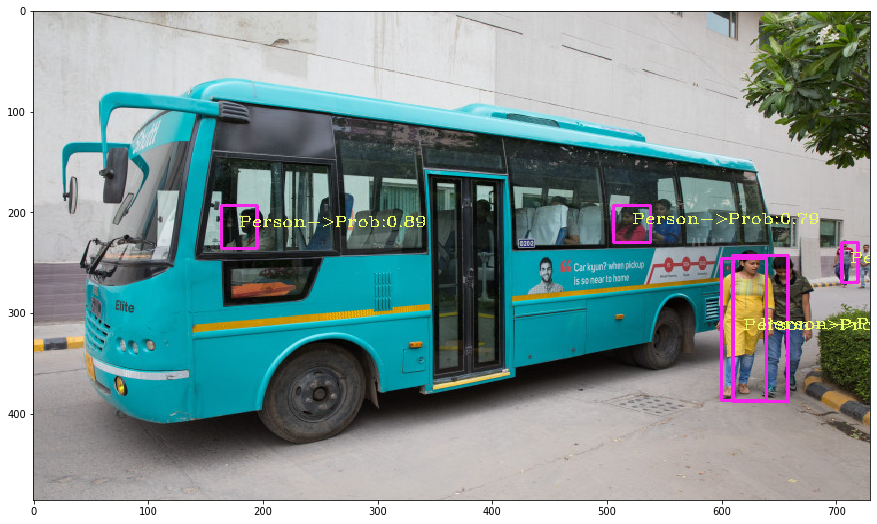

In [20]:
args.prob_threshold = 0.75
args.input = '/media/praveenkanna/Local disk/Workspace/People_counter_pytorch/People_counter/Shuttl-Pic-1.jpg'
args.Type_of_media = "image"
args.Device = 'CPU'

net_input_shape = net.get_input_shape()['image_tensor']
net_shape = (net_input_shape[3], net_input_shape[2])


client = connect_mqtt()
infer_on_stream(net,args, client,net_shape)

In [10]:
args.Type_of_media = "video"
args.prob_threshold = 0.1
args.input = '/media/praveenkanna/Local disk/Workspace/People_counter_pytorch/Pedestrian_Detect_2_1_1.mp4'
args.Device = 'GPU'

net_input_shape = net.get_input_shape()['image_tensor']
net_shape = (net_input_shape[3], net_input_shape[2])

client = connect_mqtt()
infer_on_stream(net,args, client,net_shape)

Successfully processed video and saved the file
